# Deterministic Optimization Algorithms

An overview over the different types of optimization algorithms is given in the table below.

Deterministic | Stochastic
:------- | :-------
Steepest Descent  | Monte Carlo
Conjugate Gradient Method  | Simulated Annealing
Modified Newton's Method | Evolutionary Algorithms     |
Quasi-Newton's Method |
Barrier/Penalty Methods |
SLP, SQP |

The deterministic optimization algorithms which are shown in this notebook are the steepest descent, conjugate gradient descent method, modified newton's method, quasi-newton method's, barrier/penalty methods, and SLP/SQP.
All of the above belong to the class of local optimization algorithms which use gradient information in order to find the optimum.
These algorithms have the ability to approach a solution rapidly, but only locally.

## Problem Setup

The problem which is going to be looked at is taken from the Multidisciplinary Design Optimization lecture held at the Technical University of Munich. Herein, the following engineering problem is given:

---
**Engineering Problem**

Find the optimum cross sectional areas $A_1$ and $A_2$ for the best stiffness, i.e. minimum displacement, with constrained mass $m$.
The mathematical problem forumlation is given as:

$$  \text{min. } f(A_1, A_2) = \dfrac{C_1}{A_1} + \dfrac{C_2}{A_2}  $$
$$ \text{subject to } g(A_1, A_2) = \left(  \sqrt{2} A_1 + A_2 \right) - C_3 \leq 0 \\ 1 \leq A_i < +\infty \quad \forall i \in \lbrace 1, 2 \rbrace $$

A schematic view of the problem is given in the following figure:

![Info](./figs/Problem.PNG)

---

Within this notebook, the cross sectional areas $A_1$ and $A_2$ are represented by the variables ``x`` and ``y``.
The original problem is transformed into an unconstraint problem by using a barrier function defined as: 
$$ \Psi \left( \vec{x} \right) =f \left( \vec{x} \right) + r B \left( \vec{x} \right) \quad r > 0  $$
Herein, $B \left( \vec{x} \right)$ is the barrier function which can be defined as
- $B \left( \vec{x} \right) = - \sum_{j=1}^{m} \ln \left[ -g_j \left( \vec{x} \right) \right]$ logarithmic barrier function
- $B \left( \vec{x} \right) = - \sum_{j=1}^{m}  -g_j^{-1} \left( \vec{x} \right) $ reciprocal barrier function


In [1]:
from typing import Callable

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from scipy.linalg import norm, solve

# use the searborn style
plt.style.use("seaborn")
# make interactive plots
plt.ion()

# %matplotlib qt
%matplotlib inline

## Steepest Descent

The pseudo code for the steepest descent algorithm is shown below:
````
INIT k = 0
INIT x_k as start vector
WHILE k greater than 0
    INIT search_direction as negative gradient of f evaluated at x_k
    INIT x_k+1 as x_k + alpha_k times search_direction
    k <- k + 1
    IF convergence_test is True
        break
    ENDIF
ENDWHILE
````

In [2]:
# define the range for the cross sectional areas
start, stop, step = 0, 400.5, 0.5  # start, stop, and step value
x, y = np.arange(start, stop, step, dtype=float), np.arange(start, stop, step, dtype=float)
X, Y = np.meshgrid(x, y)

def inequality_constraint(*varargs):
    x, y = varargs
    c_3 = 362.03
    return np.sqrt(2) * x + y - c_3

def objective_function(*varargs) -> np.ndarray:
    """The objective function with barrier function.

    Parameters
    ----------
    varargs : tuple
        A tuple of input variables representing the coordinates.

    Returns
    -------
    np.ndarray
        The objetive function evaluated at the input coordinates.
    """
    x, y = varargs
    c_1 = 13.47
    c_2 = 4.76
    c_3 = 362.03
    r = 0.5
    return c_1 / x + c_2 / y - r / inequality_constraint(x, y)

obj_function = objective_function(X, Y)

# define a start vector x_0
# define a random number generator
# rng = np.random.default_rng(987)
# x_rand, y_rand = rng.choice(x), rng.choice(y)
# x_0 = np.array([x_rand, y_rand], dtype=float)
x_0 = np.array([100, 50], dtype=float)
f_0 = objective_function(*x_0)

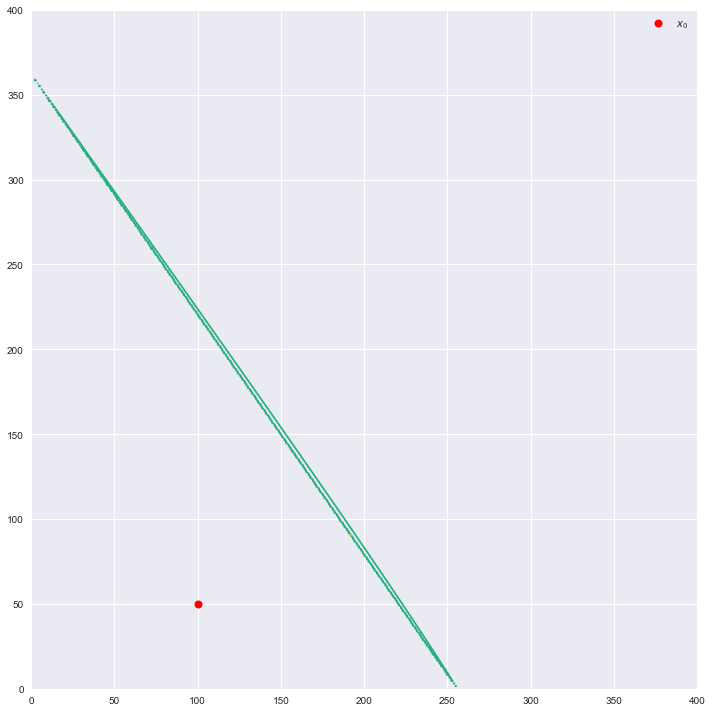

In [3]:
nrows, ncols = 1, 1
fig1 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(nrows, ncols, figure=fig1)
ax1 = fig1.add_subplot(gs[0, 0])

ax1.plot(x_0[0], x_0[1], color="r", marker="o", ms=8, ls="", label=r"$x_0$")
ax1.contour(X, Y, obj_function, levels=10, cmap="viridis")
ax1.legend(bbox_to_anchor=(1, 1))

fig1.tight_layout()

In [4]:
def central_difference(fun: Callable, x_k: np.ndarray, delta_x: float, delta_y: float) -> np.ndarray:
    """Central difference scheme.

    Parameters
    ----------
    fun : Callable
        The function which is evaluated.
    x_k : np.ndarray
        The current vector.
    delta_x : float
        The step size in x-direction.
    delta_y : float
        The step size in y-direction.

    Returns
    -------
    np.ndarray
        The normalized gradient.
    """
    x, y = x_k
    grad_x = (fun(x + delta_x, y) - fun(x - delta_x, y)) / (2 * delta_x)
    grad_y = (fun(x, y + delta_y) - fun(x, y - delta_y)) / (2 * delta_y)
    grad = np.array([grad_x, grad_y], dtype=float)
    return grad / norm(grad)

def step_size(fun: Callable, gun: Callable, grad: np.ndarray, x_k: np.ndarray, l_b: float, u_b: float, epsilon: float, limit: int):
    alpha_k = np.zeros((limit, 2), dtype=float)
    alpha_k[0, :] = x_k
    alpha_k[1, :] = x_k + u_b * grad
    r = 0.618  # golden ratio, TODO: Unused!
    loop_limit = 1e2
    i = 0
    while i <= loop_limit:
        if (fun(*alpha_k[1, :]) < fun(*alpha_k[0, :]) and gun(*alpha_k[1, :]) < 1e-3 and np.all(alpha_k[1, :] >= l_b)):
            print(f"Break at i={i}")
            break
        l_b = 0
        u_b *= 0.5
        alpha_k[1, :] = x_k + u_b * grad
        print(f"alpha k = {alpha_k[1, :]}")
        i += 1
    assert i != loop_limit, f"Could not find a solution."
    i = 2
    b_step = 2
    bracket = [l_b, u_b]
    while i <= limit:
        b = bracket[i-1] + bracket[i-1] * b_step
        bracket.append(b)
        alpha_k[i, :] = x_k + bracket[i] * grad
        if (fun(alpha_k[i-2, 0], alpha_k[i-2, 1]) > fun(alpha_k[i-1, 0], alpha_k[i-1, 1])) and (fun(alpha_k[i-1, 0], alpha_k[i-1, 1]) < fun(*alpha_k[i, :])) and (gun(*alpha_k[i, :]) < -1e-3) and np.all(alpha_k[i, :] >= l_b):
            break
        i += 1
        if i > limit or gun(*alpha_k[i-1, :]) > -1e-3 or np.any(alpha_k[i-1, :] < l_b):
            b_step *= 0.5
            bracket = [bracket[0], bracket[1]]
            i = 2
    # approximation
    a = np.zeros((3, 2), dtype=float)
    alpha = np.array([bracket[i-2], bracket[i-1], bracket[i]], dtype=float).reshape((-1, 1))
    a = x_k + alpha * grad.reshape((-1, 1)).transpose()
    u = fun(a[:, 0], a[:, 1])
    b_ = np.array([[1, alpha[0], alpha[0] ** 2],
                   [1, alpha[1], alpha[1] ** 2],
                   [1, alpha[2], alpha[2] ** 2]], dtype=float)
    a_ = solve(b_, u)
    a_star = -a_[1] / (2 * a_[2])
    return a_star

def steepest_descent(**params: dict) -> np.ndarray:
    fun = params.get("fun")
    gun = params.get("gun")

    delta_x, delta_y = 0.1, 0.1
    x_k = params.get("x_0")
    delta_psi = fun(*x_k) - 0
    k = 0
    values = []
    while (np.abs(delta_psi) >= params.get("epsilon") and k <= params.get("k_max")):
        values.append(x_k)
        search_dir = -central_difference(fun, x_k, delta_x, delta_y)
        alpha = step_size(fun, gun, search_dir, x_k, 0., 100/3, params.get("epsilon"), 100)
        print(f"Iteration: {k}\tx_{k}: {x_k}\talpha: {alpha}\tdelta psi: {delta_psi}.\n")
        x_k_1 = x_k + alpha * search_dir
        delta_psi = fun(*x_k_1) - fun(*x_k)
        x_k = x_k_1
        k += 1
    else:
        if np.abs(delta_psi) < params.get("epsilon"):
            print(f"Iteration finished, Reached delta_psi={delta_psi:.4f}<epsilon={params.get('epsilon')}.")
        if k > params.get("k_max"):
            print(f"Iteration finished, Reached k={k}>k_max={params.get('k_max')}.")
    return np.asarray(values, dtype=float)

In [5]:
params_steepest_descent = {
    "fun": objective_function,
    "x_0": x_0,
    "epsilon": 1e-9,
    "k_max": 100,
    "gun": inequality_constraint,
}
vals = steepest_descent(**params_steepest_descent)

Break at i=0
Iteration: 0	x_0: [100.  50.]	alpha: 62.81905347522532	delta psi: 0.23283068386790226.

alpha k = [150.24435768 110.18915823]
Break at i=1
Iteration: 1	x_1: [136.05961765 101.43867664]	alpha: 12.413676291702876	delta psi: -0.07957088439429139.

alpha k = [160.96219465 116.45410554]
alpha k = [153.79344928 112.20516047]
Break at i=2
Iteration: 2	x_2: [146.62470391 107.95621539]	alpha: 4.4203190736723705	delta psi: -0.006597488525608014.

alpha k = [165.4067893  117.51700883]
alpha k = [157.91703512 113.86351369]
alpha k = [154.17215803 112.03676612]
Break at i=3
Iteration: 3	x_3: [150.42728094 110.21001855]	alpha: 2.132002443387375	delta psi: -0.0011340540701517687.

alpha k = [165.76407287 101.26217056]
alpha k = [159.05376735 106.20345019]
alpha k = [155.6986146 108.67409  ]
alpha k = [154.02103822 109.90940991]
Break at i=4
Iteration: 4	x_4: [152.34346184 111.14472982]	alpha: 1.4910072686673441	delta psi: -0.00017386792761778236.

alpha k = [143.77793612  96.7550663 ]
al

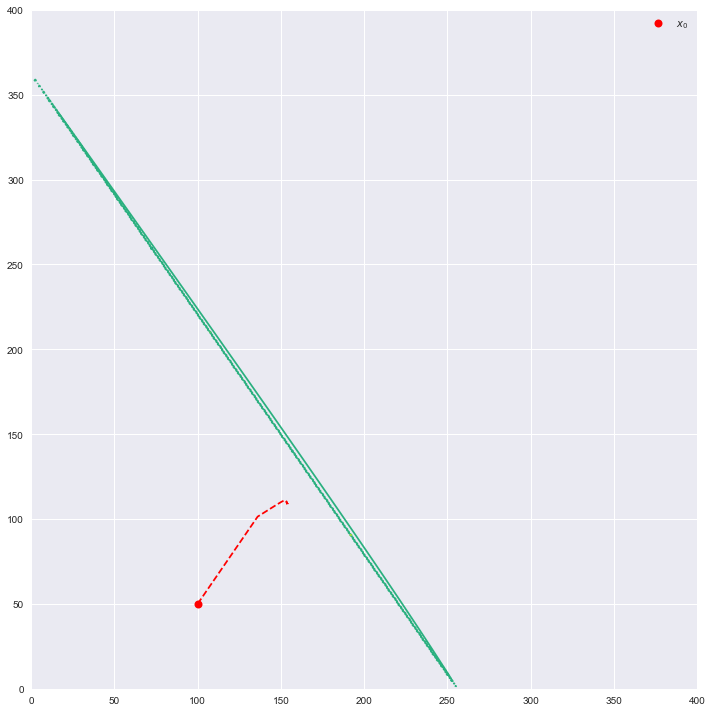

In [6]:
ax1.plot(vals[:, 0], vals[:, 1], "r--")
fig1